In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv

In [2]:
# Read the CSV files
df1 = pd.read_csv('data_cleaned_fr_100000.csv')
df2 = pd.read_csv('bbc_cleaned_fr.csv')

# Concatenate vertically (stacking rows)
merged_df = pd.concat([df1, df2], ignore_index=True)

# Save to new CSV
merged_df.to_csv('merged_file.csv', index=False)


In [3]:
temp = []  # Temporary list to store filtered rows
categories = set()  # Set to track unique categories
convert = {  # Dictionary to map categories to standardized labels
    '': "skip", 'conspiracy': 0, 'satire': 0, 'reliable': 1,
    'unreliable': 'skip', 'junksci': 0, 'unknown': 'skip',
    'political': 'skip', 'fake': 0, 'hate': 0,
    'clickbait': 1, 'bias': 'skip', 'rumor': 0, '1' : 1, '0' : 0
}

# I have chosen to ommit the categories 'unknown', 'political' and 'bias' as I don't think they can be correctly identified as either fake or real news.
# Keeping them out will help the model better distinquize between real and fake news and avoid getting them mixed

fakeCount = 0  # Counter for fake news articles
realCount = 0  # Counter for reliable news articles

with open("merged_file.csv", "r") as src:  # Open CSV file for reading
    reader = csv.reader(src)  # Create a CSV reader object
    header = next(reader)  # Read and discard the header row
    
    for row in reader:  
        content = row[4]  # Extract category from the fourth column
        categories.add(content)  # Store the unique category
        
        row[4] = convert[row[4]]  # Convert category using the dictionary
        
        if row[4] == 0:  
            fakeCount += 1  # Increment fake count
        elif row[4] == 1:
            realCount += 1  # Increment real count
        
        if row[4] != "skip":  # Skip unwanted categories
            temp.append(row)  # Append valid rows to the list

# Create a DataFrame from the filtered list, keeping the original column names
df = pd.DataFrame(temp, columns=header)

# Save the processed data to a new CSV file without renaming columns
df.to_csv('merged_file.csv', index=False)

# Load the dataset
train_data = pd.read_csv("merged_file.csv")

# Print the ratio of fake vs. real news articles and number of articles
print(f"Ratio of fakes: {fakeCount/(fakeCount+realCount)}")
print(f"Ratio of real: {realCount/(fakeCount+realCount)}")
print(f"Number of articles left: {len(temp)}")

Ratio of fakes: 0.35661425121579365
Ratio of real: 0.6433857487842064
Number of articles left: 89859


/var/folders/bz/syl68_696d58q0wgz534rs3m0000gn/T/ipykernel_20696/1848978812.py:41: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv("merged_file.csv")


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

target_column = 'type'  # Replace with your actual target column name

# Check if target column exists
if target_column not in train_data.columns:
    raise ValueError(f"Target column '{target_column}' not found. Please specify the correct target column.")

# Split data into features and target
X = train_data['content']  # Text content
y = train_data[target_column]  # Target variable

X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.15, 
    random_state=42, 
    stratify=y
)

#X_train = pd.concat([X_train, df2], ignore_index=True)

# Check class distribution
print("\nClass distribution in training set:")
class_counts = y_train.value_counts()
print(class_counts)
print(class_counts / len(y_train) * 100)

# Create feature extraction pipeline with n-grams
feature_extraction = Pipeline([
    ('vect', CountVectorizer(
        max_features=5000,             # Limit to top 5,000 features
    )),
    #('tfidf', TfidfTransformer()),
])

# Apply feature extraction to training data
X_train_features = feature_extraction.fit_transform(X_train)
print(f"\nFeature matrix shape: {X_train_features.shape}")

# Find the minimum number of samples in any class
min_class_count = min(class_counts)
print(f"Minimum class count: {min_class_count}")


smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_features, y_train)

# Show class distribution after resampling
print("\nClass distribution after resampling:")
unique, counts = np.unique(y_train_resampled, return_counts=True)
for class_label, count in zip(unique, counts):
    print(f"Class {class_label}: {count} samples ({count/len(y_train_resampled)*100:.2f}%)")

# Train the logistic regression model on the resampled data
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_resampled, y_train_resampled)


Class distribution in training set:
type
1    49142
0    27238
Name: count, dtype: int64
type
1    64.338832
0    35.661168
Name: count, dtype: float64

Feature matrix shape: (76380, 5000)
Minimum class count: 27238

Class distribution after resampling:
Class 0: 49142 samples (50.00%)
Class 1: 49142 samples (50.00%)


LogisticRegression(max_iter=1000)

Testing the model on the validation set


Val Set Accuracy: 0.8274352696787596

Classification Report for Holdout Set:
               precision    recall  f1-score   support

           0       0.73      0.83      0.77      4807
           1       0.90      0.83      0.86      8672

    accuracy                           0.83     13479
   macro avg       0.81      0.83      0.82     13479
weighted avg       0.84      0.83      0.83     13479



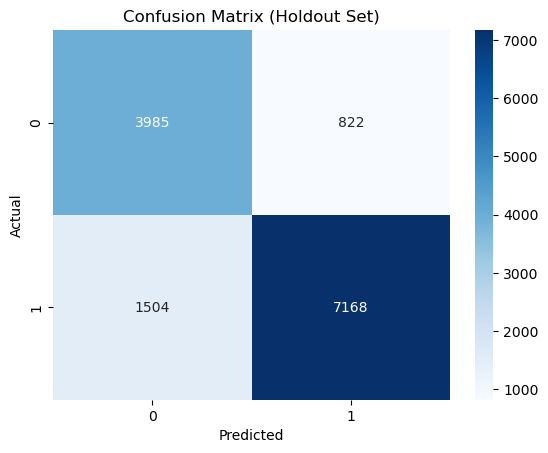

In [6]:
# Evaluate on holdout set
X_val_features = feature_extraction.transform(X_val)
y_val_pred = clf.predict(X_val_features)

print("\nVal Set Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report for Val Set:\n", classification_report(y_val, y_val_pred))

# Confusion matrix for holdout set
conf_matrix = confusion_matrix(y_val, y_val_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Val Set)')
plt.show()

Applying the model to the liars dataset


Validation Set Accuracy: 0.5539010583312823

Classification Report for Validation Set:
               precision    recall  f1-score   support

           0       0.56      0.93      0.70      4488
           1       0.51      0.09      0.16      3638

    accuracy                           0.55      8126
   macro avg       0.53      0.51      0.43      8126
weighted avg       0.54      0.55      0.45      8126



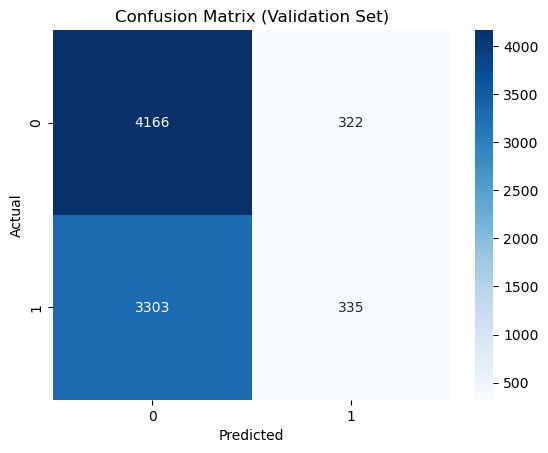

In [7]:
# Load dataset
liar_data = pd.read_csv("liars.csv")

# Define features and target
X_liar_val = liar_data['content']  # Text content
y_liar_val = liar_data[target_column]  

# Transform validation data using a pre-fitted vectorizer
liar_features = feature_extraction.transform(X_liar_val)  # No fit, just transform

# Predict using a pre-trained classifier
y_liar_val_pred = clf.predict(liar_features)

# Evaluation metrics
print("\nValidation Set Accuracy:", accuracy_score(y_liar_val, y_liar_val_pred))
print("\nClassification Report for Validation Set:\n", classification_report(y_liar_val, y_liar_val_pred))

# Confusion matrix visualization
conf_matrix = confusion_matrix(y_liar_val, y_liar_val_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Validation Set)')
plt.show()

Retraining the model with metadata 'domain_names' 

Available columns: ['Unnamed: 0.1', 'Unnamed: 0', 'id', 'domain', 'type', 'url', 'content', 'scraped_at', 'inserted_at', 'updated_at', 'title', 'authors', 'keywords', 'meta_keywords', 'meta_description', 'tags', 'summary', 'source', 'headline', 'published_date']
Features being used for training:
- text: content

Feature matrix shape after preprocessing: (76380, 5000)

Class distribution in training set:
type
1    49142
0    27238
Name: count, dtype: int64

Applying SMOTE...

Training model...

Test set evaluation:
Accuracy: 0.8547

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.83      0.80      4807
           1       0.90      0.87      0.89      8672

    accuracy                           0.85     13479
   macro avg       0.84      0.85      0.84     13479
weighted avg       0.86      0.85      0.86     13479


Feature importance analysis:

Top 20 most important words:
1. blockchain: -19.3795
2. sourc: -17.0176
3. getti:

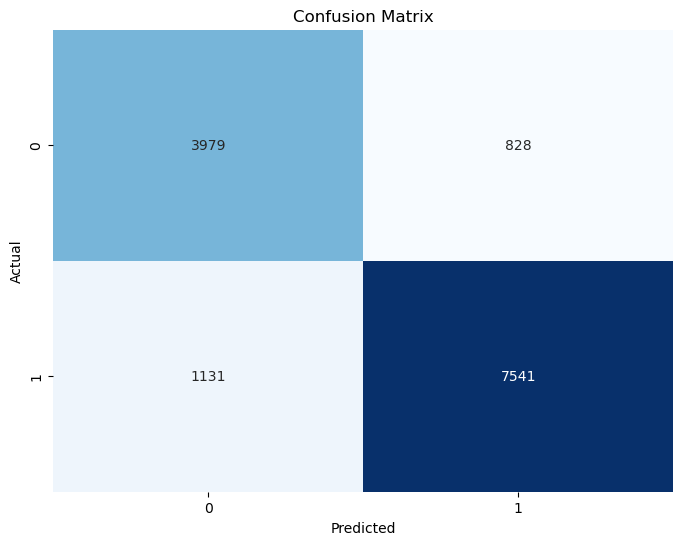

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

text_column = 'content'
target_column = 'type'

X_train, X_val, y_train, y_val = train_test_split(
    train_data.drop(columns=[target_column]), 
    train_data[target_column], 
    test_size=0.15, 
    random_state=42, 
    stratify=train_data[target_column]
)

# Additional features to include (add your own column names)
categorical_columns = ['domain_names']  # Add your categorical columns

# Check if columns exist
all_columns = [text_column] + categorical_columns + [target_column]
missing_columns = [col for col in all_columns if col not in train_data.columns]

if missing_columns:
    print(f"Warning: The following columns are missing: {missing_columns}")
    print("Available columns:", train_data.columns.tolist())
    # Filter to only use columns that exist
    categorical_columns = [col for col in categorical_columns if col in train_data.columns]

# Create the feature processing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        # Text feature processing
        ('text', Pipeline([
            ('vect', CountVectorizer(lowercase=True, max_features=5000)),
            ('tfidf', TfidfTransformer())
        ]), text_column),
        
        # Categorical feature processing
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns) if categorical_columns else None
    ],
    remainder='drop'  # Drop any other columns
)

# Remove any None transformers
preprocessor.transformers = [t for t in preprocessor.transformers if t is not None]

# Split data
X = train_data.drop(columns=[target_column])
y = train_data[target_column]

# Print feature information
print("Features being used for training:")
for name, _, columns in preprocessor.transformers:
    if isinstance(columns, list):
        print(f"- {name}: {columns}")
    else:
        print(f"- {name}: {columns}")

# Apply preprocessing
preprocessor.fit(X_train)

# Transform all three sets
X_train_features = preprocessor.transform(X_train)
X_val_features = preprocessor.transform(X_val)

print(f"\nFeature matrix shape after preprocessing: {X_train_features.shape}")

# Check class distribution
print("\nClass distribution in training set:")
class_counts = y_train.value_counts()
print(class_counts)

# Find minimum class count for SMOTE
min_class_count = min(class_counts)

# Apply SMOTE if possible
if min_class_count >= 6:
    print("\nApplying SMOTE...")
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_features, y_train)
elif min_class_count > 1:
    print(f"\nMinority class has only {min_class_count} samples. Using SMOTE with fewer neighbors...")
    k_neighbors = min(min_class_count - 1, 5)
    smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_features, y_train)
else:
    print("\nToo few samples for SMOTE. Using original data with class weights.")
    X_train_resampled, y_train_resampled = X_train_features, y_train

# Train model
print("\nTraining model...")
if min_class_count <= 1:
    # Use class weights if SMOTE can't be applied
    clf = LogisticRegression(max_iter=1000, C=1.0, class_weight='balanced')
else:
    clf = LogisticRegression(max_iter=1000, C=1.0)

clf.fit(X_train_resampled, y_train_resampled)

# Evaluate on test set
X_val_features = preprocessor.transform(X_val)
y_pred = clf.predict(X_val_features)

print("\nTest set evaluation:")
print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

print("\nFeature importance analysis:")

# Try to get feature names for text features
try:
    text_transformer = preprocessor.named_transformers_['text']
    text_features = text_transformer.named_steps['vect'].get_feature_names_out()
    
    # Get coefficients for binary classification
    if len(clf.classes_) == 2:
        coefficients = clf.coef_[0]
    else:
        # For multiclass, we'll just look at the first class for simplicity
        coefficients = clf.coef_[0]
    
    # Only show importance for text features
    n_text_features = len(text_features)
    text_importance = list(zip(text_features, coefficients[:n_text_features]))
    
    # Sort by absolute importance
    text_importance.sort(key=lambda x: abs(x[1]), reverse=True)
    
    print("\nTop 20 most important words:")
    for i, (feature, importance) in enumerate(text_importance[:20], 1):
        print(f"{i}. {feature}: {importance:.4f}")

except (KeyError, AttributeError) as e:
    print(f"Could not analyze text feature importance: {e}")

# Evaluate on validation set first
y_val_pred = clf.predict(X_val_features)
print("\nValidation set evaluation:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))

# Plot confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()